Test

In [2]:
from matplotlib import pyplot as plt
import torch
import torch.nn as nn
import os
import numpy as np
from torch import optim
from torch.nn.parallel import DistributedDataParallel as DDP
from torch.utils.tensorboard import SummaryWriter
from tqdm import tqdm
import sys
sys.path.append('utils')
from data_utils import *
import model_utils
from model_utils import *
from training_utils import *


samplerate = 16000
frame_length_ms = 12
frame_length_samples = int(samplerate * frame_length_ms / 1000)
hop_length_samples = 4
channels = 128
VRP_path = r'F:\audio\resample\test_VRP_F02'
max_VRP_audio = 1.0244186349598814
max_VRP_egg = 0.9467938058636511


import sys
print("Python executable path:", sys.executable)
# check GPU availability
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", device)

Python executable path: g:\Conda\envs\pytorch\python.exe
Device: cpu


In [3]:
# load test data in a folder
audio, egg = load_data_sf(VRP_path)
audio = voice_preprocess(audio, samplerate)
egg = process_EGG_signal(egg, samplerate)
audio = audio / max_VRP_audio
egg = egg / max_VRP_egg

# segment audio
audio_frames = segment_audio(audio, samplerate, frame_length_ms, hop_length_samples)
egg_frames = segment_audio(egg, samplerate, frame_length_ms, hop_length_samples)

# choose the first 1000 frames for testing
audio_frames = audio_frames[16000:32000]
egg_frames = egg_frames[16000:32000]

print(audio_frames.shape)

test_dataset = AudioEGGDataset(audio_frames, egg_frames)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=4, shuffle=False, num_workers=0)


Processing frames: 100%|██████████| 988/988 [00:00<00:00, 4516.72it/s]


KeyboardInterrupt: 

In [15]:
# single channel file
# load test data in a folder
audio_file = r'F:\audio\evaluation_audio\pathology\1-iau.wav'
egg_file = r'F:\audio\evaluation_audio\pathology\1-iau-egg.wav'
audio = load_audio_file_sf_mono(audio_file)
egg = load_audio_file_sf_mono(egg_file)
audio = voice_preprocess(audio, samplerate)
egg = process_EGG_signal(egg, samplerate)
audio = audio / max_VRP_audio
egg = egg / max_VRP_egg

# segment audio
audio_frames = segment_audio(audio, samplerate, frame_length_ms, hop_length_samples)
egg_frames = segment_audio(egg, samplerate, frame_length_ms, hop_length_samples)

# choose the first 1000 frames for testing
audio_frames = audio_frames[16000:32000]
egg_frames = egg_frames[16000:32000]

print(audio_frames.shape)

test_dataset = AudioEGGDataset(audio_frames, egg_frames)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=4, shuffle=False, num_workers=0)


Processing frames: 100%|██████████| 160/160 [00:00<00:00, 4996.90it/s]


(16000, 192)


In [16]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

model_path = r'F:\A2E git\A2E\Trials\Trial21_VRP_stride4\models\best_model.pt'
state_dict = torch.load(model_path, map_location=device)
model = WaveNet_a2e(input_channels=1, dilation_channels=channels, dilation_layers=7, dropout=0.3)
new_state_dict = {k.replace('module.', ''): v for k, v in state_dict.items()}
model.load_state_dict(new_state_dict)
model = model.to(device)



model.eval()
with torch.no_grad():
    predictions = []
    targets = []
    for data in test_loader:
        a, e = data
        a = a.to(device)
        e = e.to(device)
        output = model(a)
        predictions.append(output.cpu())
        targets.append(e.cpu())

predictions = torch.cat(predictions, dim=0)
targets = torch.cat(targets, dim=0)

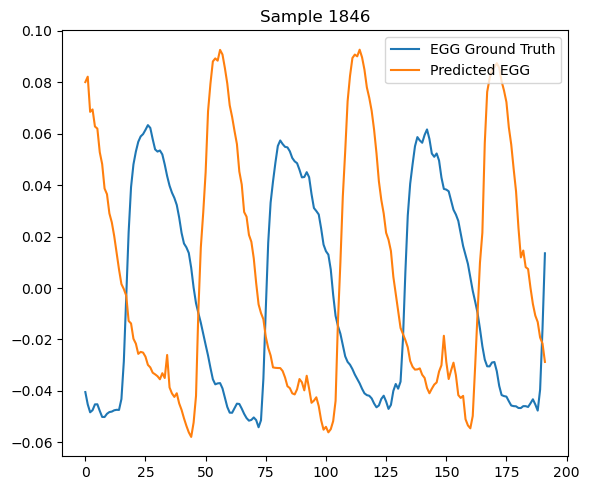

In [34]:
num_samples = 1
samples = np.random.randint(0, len(targets), size=num_samples)

plt.figure(figsize=(6, 5 * num_samples))
for i, sample in enumerate(samples, 1):
    plt.subplot(num_samples, 1, i)
    egg_sample = targets[sample].squeeze()
    output_sample = predictions[sample].squeeze()
    plt.plot(egg_sample, label='EGG Ground Truth')
    plt.plot(output_sample, label='Predicted EGG')
    plt.legend()
    plt.title(f'Sample {sample}')

plt.tight_layout()
plt.show()

In [ ]:
def overlap_and_add(frames, hop_length, frame_length_ms, samplerate):
    frame_length = int(samplerate * frame_length_ms / 1000)
    # Normalize the input frames dimensionality
    if frames.ndim == 3:
        frames = frames.reshape(frames.shape[0], frames.shape[2])  # Converts [16000, 1, 192] to [16000, 192]
    elif frames.ndim != 2:
        raise ValueError("Input frames must be 2D or 3D with last dimension as frame length.")

    output_length = hop_length * (frames.shape[0] - 1) + frame_length
    output = np.zeros(output_length)
    window = np.hanning(frame_length)
    normalization = np.zeros(output_length)

    for i in range(frames.shape[0]):
        start = i * hop_length
        end = start + frame_length
        output[start:end] += frames[i, :] * window
        normalization[start:end] += window

    normalization[normalization == 0] = 1
    output /= normalization  # Normalize to maintain original signal amplitude

    return output

output = overlap_and_add(predictions.numpy(), hop_length_samples, frame_length_ms, samplerate)
target = overlap_and_add(targets.numpy(), hop_length_samples, frame_length_ms, samplerate)
audio_input = overlap_and_add(audio_frames, hop_length_samples, frame_length_ms, samplerate)

plt.figure(figsize=(10, 5))
plt.plot(target, label='Ground Truth')
plt.plot(output, label='Predicted')
plt.legend()
plt.show()

In [ ]:
from scipy.io.wavfile import write as save_audio

# save the predicted audio and EGG
output_path = r'F:\A2E git\A2E\output\Trial21_VRP_stride4'
os.makedirs(output_path, exist_ok=True)
save_audio(os.path.join(output_path, 'output_t.wav'), samplerate, output)
save_audio(os.path.join(output_path, 'target_t.wav'), samplerate, target)
save_audio(os.path.join(output_path, 'input_t.wav'), samplerate, audio_input)

print('Audio saved to:', os.path.join(output_path, 'output_test.wav'))
print('EGG saved to:', os.path.join(output_path, 'target_test.wav'))
print('Input audio saved to:', os.path.join(output_path, 'input_test.wav'))
